# GPU and Libraries

In [1]:
import sys
print(sys.version)

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


 **Checking for GPU**

In [2]:
import torch
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


**Importing Libraries**

In [14]:
import os
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, regularizers, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from scipy import stats
import shutil
import random
from sklearn.metrics import confusion_matrix

# Necessary Functions

In [15]:
def dataset_basic_info(generator, name):
        print('The ' + name + ' data set includes ' + str(generator.samples) + ' samples.')
        print('The ' + name + ' image shapes is ' + str(generator.image_shape))
        keys = [el for el in generator.class_indices.keys()]
        print('The ' + name + ' data set includes the following labels: ')
        print(keys)
        labels     = generator.labels
        cat_labels = []
        for i in range(len(labels)):
            for j in range(len(keys)):
                if (labels[i] == j):
                    cat_labels.append(keys[j])
                    break
        occurrences = []
        for key in keys:
            counter = 0
            for i in range(len(cat_labels)):
                if cat_labels[i] == key:
                    counter += 1
            occurrences.append(counter)
        print(name + ' data set labels frequencies:')
        weights = {}
        for i in range(len(keys)):
            print(keys[i] + ': ' + str(occurrences[i]) + ' (absolute), ' + str(round(occurrences[i]/float(generator.samples), 3)) + ' (relative).' )
            weights[i] = generator.samples/np.array(occurrences[i])*(1.0/float(len(keys)))
        
        return weights

In [16]:
def build_model_cnn(regression_problem, conv_filters, conv_filter_shape, conv_activation_function, conv_padding, conv_pooling_type,
                    conv_pooling_shape, hidden_layers_neurons, hidden_activation_function, L1_coeffs, L2_coeffs, hidden_layers_dropout, 
                    final_layer_neurons, final_activation_function, shape, model_optimizer, loss_function, metrics):
    
    model = models.Sequential()
    
    for i in range(len(conv_activation_function)):
        
        if (i == 0):
            model.add(layers.Conv2D(conv_filters[i],
                                    (conv_filter_shape[i][0],conv_filter_shape[i][1]), 
                                    activation = conv_activation_function[i], 
                                    padding    = conv_padding[i],
                                    input_shape = (shape[0],shape[1],shape[2])))             
        else:
            model.add(layers.Conv2D(conv_filters[i],
                                    (conv_filter_shape[i][0],conv_filter_shape[i][1]), 
                                    activation = conv_activation_function[i],
                                    padding    = conv_padding[i]))
        
        if (conv_pooling_type[i] == 'max'):
            model.add(layers.MaxPooling2D((conv_pooling_shape[i][0],conv_pooling_shape[i][1])))
        elif (conv_pooling_type[i] == 'avg'):
            model.add(layers.AveragePooling2D((conv_pooling_shape[i][0],conv_pooling_shape[i][1])))
        else:
            'no pooling'
            
    model.add(layers.Flatten())
    
    for i in range(len(hidden_activation_function)):

        model.add(layers.Dense(hidden_layers_neurons[i], 
                               kernel_regularizer = regularizers.l1_l2(l1 = L1_coeffs[i], l2 =  L2_coeffs[i]),  
                               activation=hidden_activation_function[i]))
        if (hidden_layers_dropout[i] > 0.0):
            model.add(layers.Dropout(hidden_layers_dropout[i]))
    if regression_problem:
            model.add(layers.Dense(final_layer_neurons))
    else:
            model.add(layers.Dense(final_layer_neurons,activation = final_activation_function))
            
    model.compile(optimizer = model_optimizer, loss = loss_function, metrics = metrics)
    
    model.summary()
    
    return model

def build_model_pretrained_cnn(pre_trained_model, include_top, regression_problem, hidden_layers_neurons, hidden_activation_function, 
                               L1_coeffs, L2_coeffs, hidden_layers_dropout, final_layer_neurons, final_activation_function, model_optimizer, 
                               loss_function, metrics):
    
    model = models.Sequential()
    model.add(pre_trained_model)
    
    if (include_top == False):
        
            model.add(layers.Flatten())

            for i in range(len(hidden_activation_function)):

                model.add(layers.Dense(hidden_layers_neurons[i], 
                                       kernel_regularizer = regularizers.l1_l2(l1 = L1_coeffs[i], l2 =  L2_coeffs[i]),  
                                       activation=hidden_activation_function[i]))
                if (hidden_layers_dropout[i] > 0.0):
                    model.add(layers.Dropout(hidden_layers_dropout[i]))
            if regression_problem:
                    model.add(layers.Dense(final_layer_neurons))
            else:
                    model.add(layers.Dense(final_layer_neurons,activation = final_activation_function))
            
    model.compile(optimizer = model_optimizer, loss = loss_function, metrics = metrics)
    
    model.summary()
    
    return model

In [17]:
def display_input_images(generator, max_n_figures, batch_size, grid_size, fig_size):
    
    fig_counter = 0
    for image_batch, label_batch in generator: 
        plt.figure(figsize=(fig_size[0],fig_size[1]))
        for j in range(batch_size):
            ax   = plt.subplot(grid_size[0], grid_size[1], j + 1)
            plt.imshow(image_batch[j])
            if (label_batch[j][0] == 1):
                    plt.title('MildDemented')
            elif (label_batch[j][1] == 1):
                    plt.title('ModerateDemented')
            elif (label_batch[j][2] == 1):
                    plt.title('NonDemented')
            else:
                    plt.title('VeryMildDemented')
            plt.axis("off")
        plt.show()
        fig_counter += 1
        if (fig_counter == max_n_figures): break

In [18]:
def analyze_performances(hst, epochs):
    history_dict             = hst.history
    loss_values              = history_dict['loss']
    validation_loss_values   = history_dict['val_loss']
    acc_values               = history_dict['categorical_accuracy']
    validation_acc_values    = history_dict['val_categorical_accuracy']
    auc_values               = history_dict['multiclass_AUC']
    validation_auc_values    = history_dict['val_multiclass_AUC']
    epochs                   = range(1,len(loss_values) + 1)
    fig, axes                = plt.subplots(1,3,figsize = (30,10))
    training_ts              = [loss_values, acc_values, auc_values]
    validation_ts            = [validation_loss_values, validation_acc_values, validation_auc_values]
    metric_names             = ['loss', 'categorical accuracy','average multiclass AUC']
    for i in range(len(axes)):
        axes[i].plot(epochs,training_ts[i],color = 'r',label = 'training')
        axes[i].plot(epochs,validation_ts[i],color = 'b',label = 'validation')
        axes[i].set_xlabel('epoch')
        axes[i].set_ylabel(metric_names[i])
        axes[i].set_title(metric_names[i] + ' analysis')
        axes[i].set_xticks(np.arange(0,epochs[-1] + 1,5))
        axes[i].set_yticks(np.arange(0,1.1,0.1))
        axes[i].set_xlim([1,epochs[-1]])
        axes[i].set_ylim([np.min([np.min(training_ts[i]),np.min(validation_ts[i])]),np.max([np.max(training_ts[i]),np.max(validation_ts[i])])])
        axes[i].legend()
    plt.show()

In [19]:
def model_evaluation(model, test_generator):
    test_loss_1, test_acc_1, test_auc_1 = model.evaluate_generator(test_generator, verbose=0)
    print('The value of the loss function on the test data set is: ' + str(round(test_loss_1,4)))
    print('The categorical accuracy of the predictions on the test data set is: ' + str(round(test_acc_1,4)))
    print('The categorical AUC (i.e., average curve across classes) of the predictions on the test data set is: ' + str(round(test_auc_1,4)))
    
    class_labels = list(test_generator.class_indices.keys())
    predictions = []
    true        = []
    ctr         = 0
    for batch, label in test_generator:
        prediction = model.predict(batch).argmax(axis = -1)
        predictions.extend(prediction)
        true.extend(label.argmax(axis = -1))
        ctr += len(prediction)
        if ctr >= len(test_generator.labels):
            break
            
    matrix     = confusion_matrix(true,predictions)
    rel_matrix = matrix/np.sum(matrix,axis = 0)
    fig, axes  = plt.subplots(1,2,figsize = (20,40))

    image1 = axes[0].imshow(matrix, cmap=plt.get_cmap('GnBu'))
    for (i, j), e in np.ndenumerate(matrix):
        axes[0].text(j, i, s = str(e), ha='center', va='center')
    axes[0].set_xticks(np.arange(0,len(class_labels), 1))
    axes[0].set_xticklabels(class_labels)
    axes[0].set_yticks(np.arange(0,len(class_labels), 1))
    axes[0].set_yticklabels(class_labels)
    axes[0].set_title('Confusion Matrix')
    
    image2 = axes[1].imshow(matrix/np.sum(matrix,axis = 0), cmap=plt.get_cmap('GnBu'))
    for (i, j), e in np.ndenumerate(rel_matrix):
        axes[1].text(j, i, s = str(np.round(e,2)), ha='center', va='center')
    axes[1].set_xticks(np.arange(0,len(class_labels), 1))
    axes[1].set_xticklabels(class_labels)
    axes[1].set_yticks(np.arange(0,len(class_labels), 1))
    axes[1].set_yticklabels(class_labels)
    plt.subplots_adjust(wspace = 0.5)
    axes[1].set_title('Confusion Matrix (Relative)')                      
    plt.show()

# Getting Data

In [9]:
# Geting our drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
training_path                  =  "/content/drive/MyDrive/Colab Notebooks/Alzheimers disease /Dataset/train"
test_path                      =  "/content/drive/MyDrive/Colab Notebooks/Alzheimers disease /Dataset/test"
validation_split               = 0.20
regression_problem             = False
target_img_shape_1             = 224
target_img_shape_2             = 224
target_img_channels            = 3
conv_layers                    = 4
conv_filters                   = [32,64,128,128]   
conv_filter_shape              = [[3,3]]*conv_layers
conv_activation_function       = ['relu']*conv_layers
conv_padding                   = ['valid']*conv_layers
conv_pooling_type              = ['max']*conv_layers
conv_pooling_shape             = [[2,2]]*conv_layers
augment_data                   = True
rotation_range                 = 0.1
width_shift_range              = 0.1
height_shift_range             = 0.1
shear_range                    = 0.1
brightness_range               = [0.8,1.2]
zoom_range                     = 0.1
horizontal_flip                = False
fill_mode                      = 'nearest'
print_sample_input             = True
hidden_activation_function     = ['relu']
hidden_layers_neurons          = [128]
hidden_layers_L1_coeffs        = [0.00]
hidden_layers_L2_coeffs        = [0.00]
hidden_layers_dropout          = [0.00]
final_activation_function      = 'softmax'
final_layer_neurons            = 4
model_optimizer                = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss_function                  = 'categorical_crossentropy'
metrics                        = [metrics.CategoricalAccuracy(name='categorical_accuracy'),
                                  metrics.AUC(multi_label = True, name='multiclass_AUC')]
n_epochs                       = 40
batch_size                     = 40
validation_steps               = 50
vgg_include_top                = False
vgg_hidden_activation_function = ['relu']
vgg_hidden_layers_neurons      = [128]
vgg_hidden_layers_L1_coeffs    = [0.00]
vgg_hidden_layers_L2_coeffs    = [0.00]
vgg_hidden_layers_dropout      = [0.00]
vgg_final_activation_function  = 'softmax'
vgg_final_layer_neurons        = 4
vgg_model_optimizer            = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
vgg_n_epochs                   = 40
vgg_validation_steps           = 50

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Copying Data to another folder

In [26]:
labels              = ['MildDemented','ModerateDemented','NonDemented', 'VeryMildDemented']
new_training_path   = "../files/alzheimers-dataset-4-class-of-images/dataset1/training_set/"
new_validation_path = "../files/alzheimers-dataset-4-class-of-images/dataset1/validation_set/"
new_test_path       = "../files/alzheimers-dataset-4-class-of-images/dataset1/test_set/"
shutil.rmtree(new_training_path, ignore_errors=True)
shutil.rmtree(new_validation_path, ignore_errors=True) 
shutil.rmtree(new_test_path, ignore_errors=True)
[os.makedirs(new_training_path + label,exist_ok=True) for label in labels]
[os.makedirs(new_validation_path + label,exist_ok=True) for label in labels]
[os.makedirs(new_test_path + label,exist_ok=True) for label in labels]
training_label_frequencies   = []
for label in labels:
        training_filenames   = os.listdir(training_path +  "/"+ label) 
        validation_filenames = random.sample(training_filenames, int(len(training_filenames)*validation_split))
        training_filenames   = [file for file in training_filenames if file not in validation_filenames]
        test_filenames       = os.listdir(test_path + "/"+ label) 
        for file in training_filenames:
            shutil.copy(training_path  + "/"+ label + "/" + file, new_training_path + label + "/" + file)
        print('Training images transfer complete for label: ' + label + '. # transferred images: ' + str(len(training_filenames)))
        for file in validation_filenames:
            shutil.copy(training_path  + "/" + label + "/" + file, new_validation_path + label + "/" + file)
        print('Validation images transfer complete for label: ' + label + '. # transferred images: '  + str(len(validation_filenames)))
        for file in test_filenames:
            shutil.copy(test_path  + "/" + label + "/"  + file, new_test_path + label + "/" + file)
        print('Test images transfer complete for label: ' + label + '. # transferred images: '  + str(len(test_filenames)))
        
        training_label_frequencies.append(len(training_filenames))

Training images transfer complete for label: MildDemented. # transferred images: 4000
Validation images transfer complete for label: MildDemented. # transferred images: 1000
Test images transfer complete for label: MildDemented. # transferred images: 1000
Training images transfer complete for label: ModerateDemented. # transferred images: 4000
Validation images transfer complete for label: ModerateDemented. # transferred images: 1000
Test images transfer complete for label: ModerateDemented. # transferred images: 1000
Training images transfer complete for label: NonDemented. # transferred images: 4000
Validation images transfer complete for label: NonDemented. # transferred images: 1000
Test images transfer complete for label: NonDemented. # transferred images: 1000
Training images transfer complete for label: VeryMildDemented. # transferred images: 4000
Validation images transfer complete for label: VeryMildDemented. # transferred images: 1000
Test images transfer complete for label: 

In [27]:
training_label_frequencies = np.array(training_label_frequencies)
target_n_samples           = np.max(training_label_frequencies)
for i in range(len(labels)):
    current_label     = labels[i]
    n_missing_samples = target_n_samples - training_label_frequencies[i]
    filenames         = os.listdir(new_training_path + current_label + "/") 
    n_filled          = np.zeros(len(filenames))
    while (np.sum(n_filled) < n_missing_samples):
          idx = np.random.randint(0,len(filenames))
          shutil.copy(new_training_path +"/" + current_label + "/" + filenames[idx], new_training_path + "/" + current_label + "/" + filenames[idx].replace(".jpg", "_copy_" + str(int(n_filled[idx] + 1)) + ".jpg"))
          n_filled[idx] += 1
    

In [28]:
if augment_data:
    train_datagen   = ImageDataGenerator(rescale            = 1./255,
                                         rotation_range     = rotation_range,
                                         width_shift_range  = width_shift_range,
                                         height_shift_range = height_shift_range,
                                         shear_range        = shear_range,
                                         brightness_range   = brightness_range,
                                         zoom_range         = zoom_range,
                                         horizontal_flip    = horizontal_flip,
                                         fill_mode          = fill_mode)
else:
    train_datagen   = ImageDataGenerator(rescale = 1./255)

validation_datagen   = ImageDataGenerator(rescale = 1./255)
test_datagen         = ImageDataGenerator(rescale = 1./255)
train_generator      = train_datagen.flow_from_directory(new_training_path,target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical")  
validation_generator = validation_datagen.flow_from_directory(new_validation_path,target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical") 
test_generator       = test_datagen.flow_from_directory(new_test_path,target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical")

Found 16000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.


# Visualizing Data

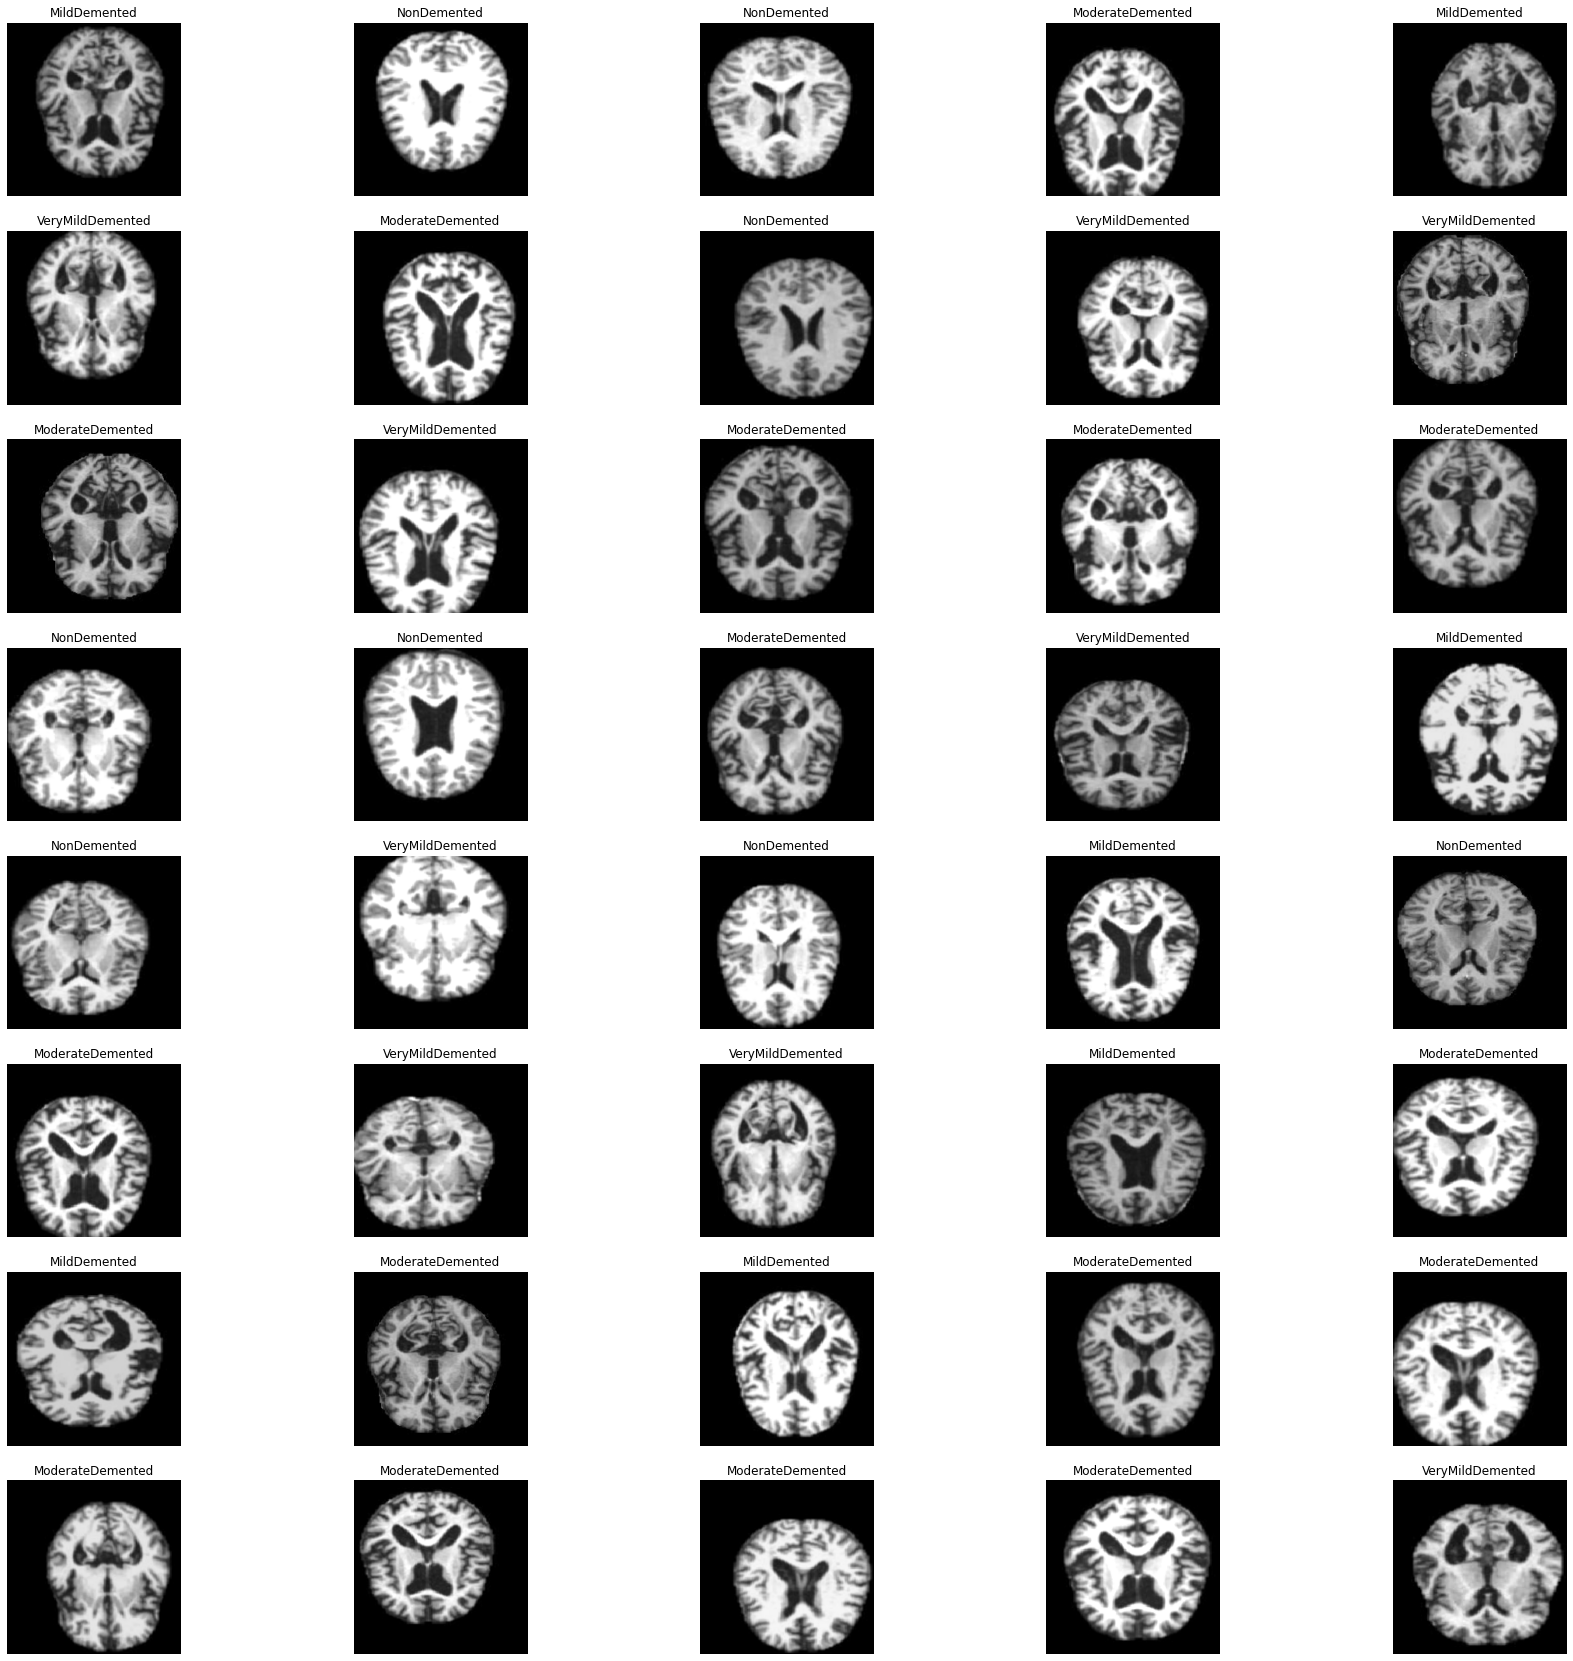

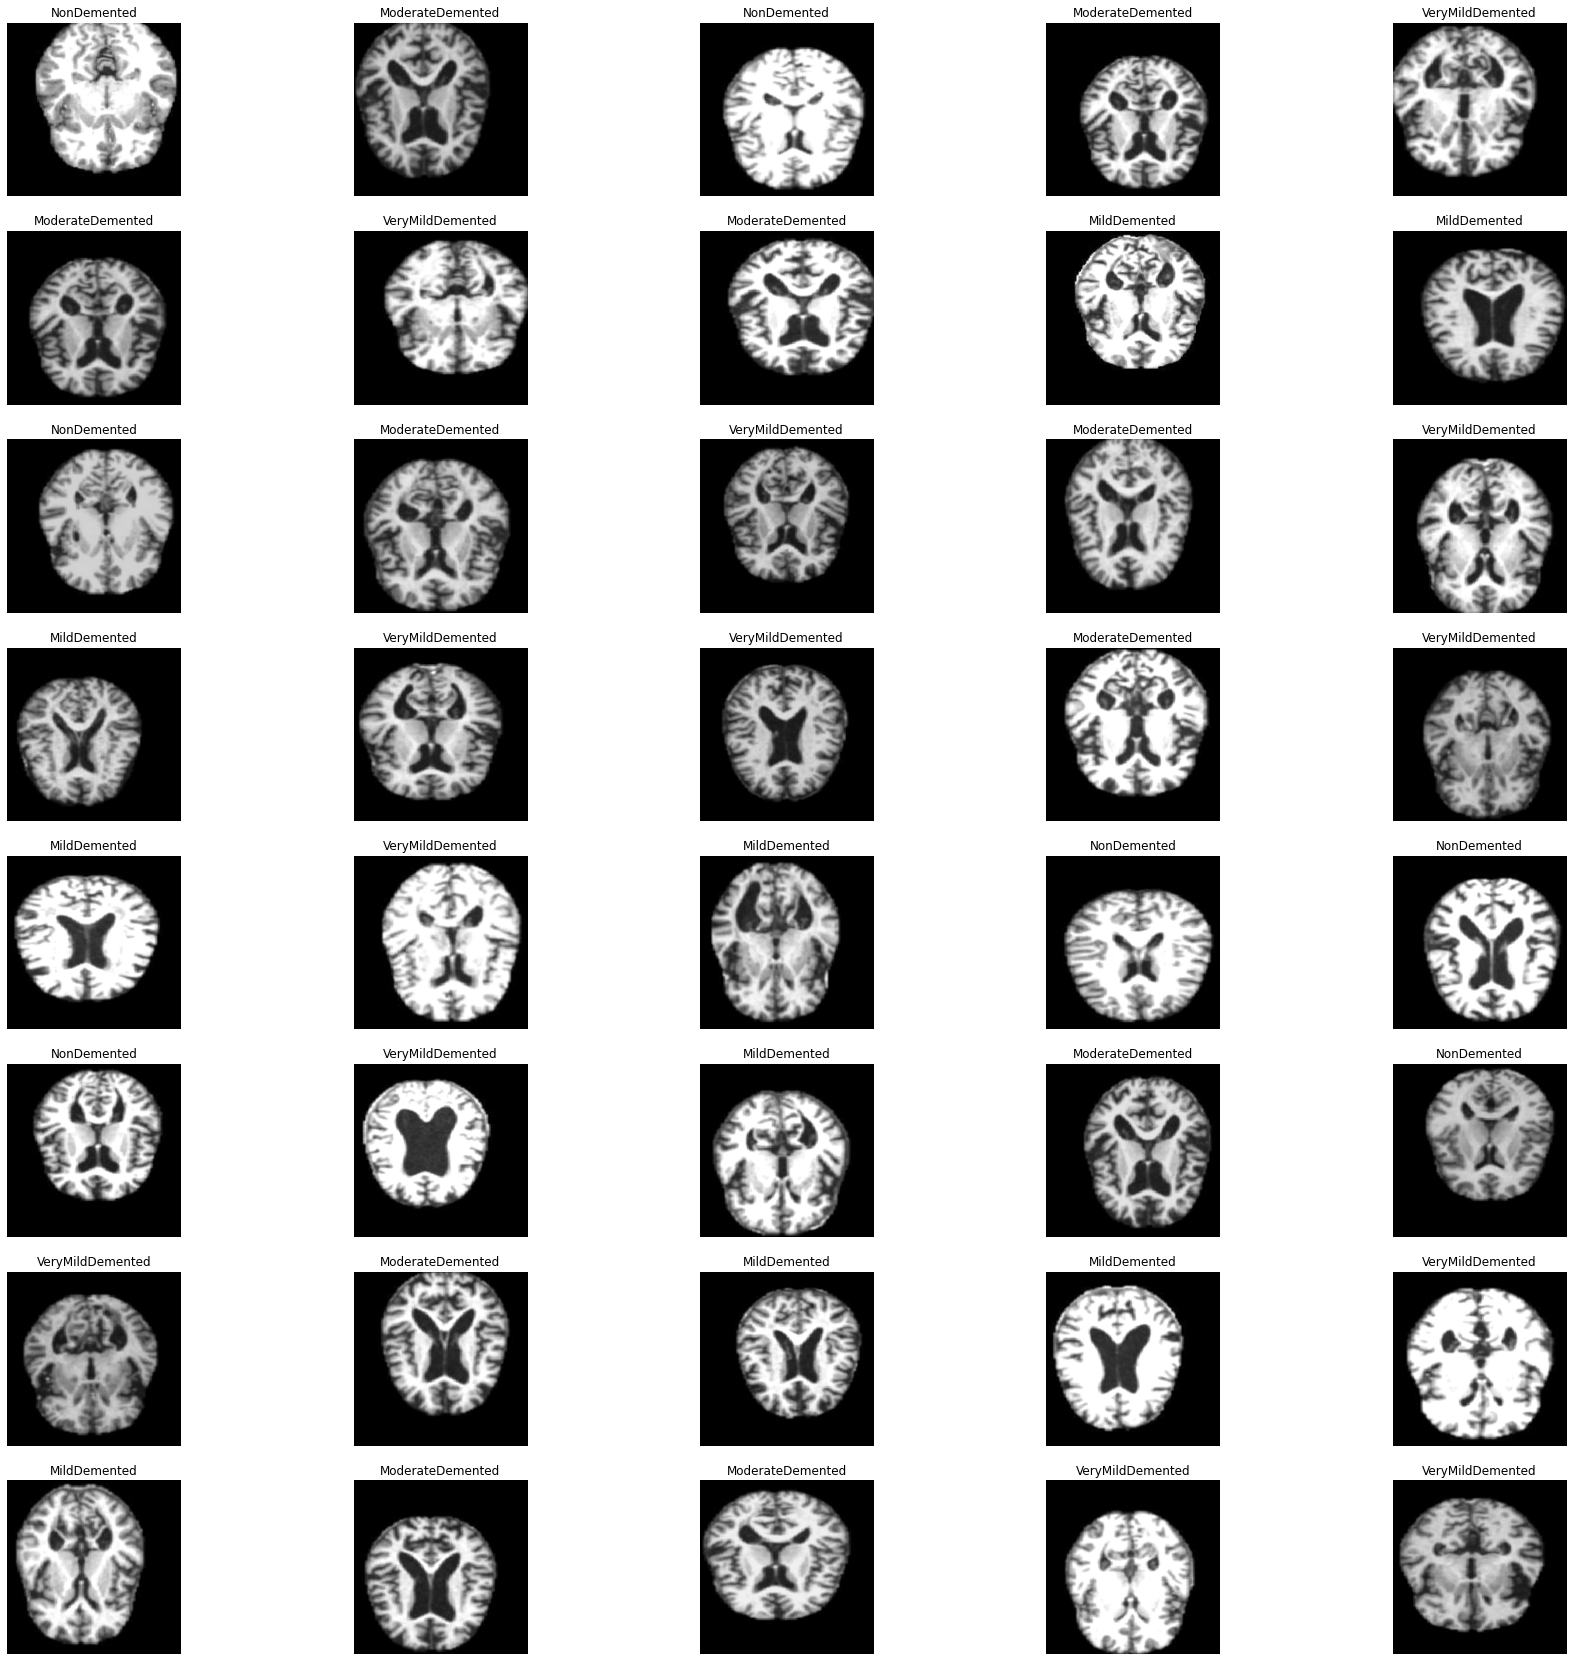

In [29]:
if print_sample_input:
    display_input_images(train_generator, 2, batch_size, [8,5], [30,30])

In [30]:
train_labels_weights_dict      = dataset_basic_info(train_generator, 'training')
validation_labels_weights_dict = dataset_basic_info(validation_generator, 'validation')
test_labels_weights_dict       = dataset_basic_info(test_generator, 'test')

The training data set includes 16000 samples.
The training image shapes is (224, 224, 3)
The training data set includes the following labels: 
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
training data set labels frequencies:
MildDemented: 4000 (absolute), 0.25 (relative).
ModerateDemented: 4000 (absolute), 0.25 (relative).
NonDemented: 4000 (absolute), 0.25 (relative).
VeryMildDemented: 4000 (absolute), 0.25 (relative).
The validation data set includes 4000 samples.
The validation image shapes is (224, 224, 3)
The validation data set includes the following labels: 
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
validation data set labels frequencies:
MildDemented: 1000 (absolute), 0.25 (relative).
ModerateDemented: 1000 (absolute), 0.25 (relative).
NonDemented: 1000 (absolute), 0.25 (relative).
VeryMildDemented: 1000 (absolute), 0.25 (relative).
The test data set includes 4000 samples.
The test image shapes is (224, 224, 3)
The test 

# Implementing the CNN

In [31]:
model = build_model_cnn(regression_problem, conv_filters, conv_filter_shape, conv_activation_function, conv_padding, 
                        conv_pooling_type, conv_pooling_shape, hidden_layers_neurons, hidden_activation_function, 
                             hidden_layers_L1_coeffs, hidden_layers_L2_coeffs, hidden_layers_dropout, 
                        final_layer_neurons, final_activation_function, [target_img_shape_1, target_img_shape_2, target_img_channels], 
                             model_optimizer, loss_function, metrics)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

**Fit the Model**

In [32]:
early_exit      = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
best_checkpoint = ModelCheckpoint('.best_fit.hdf5', save_best_only=True, monitor='val_multiclass_AUC', mode='max')

hst = model.fit(train_generator, steps_per_epoch = train_generator.samples//batch_size, epochs = n_epochs, validation_data = validation_generator, 
                validation_steps = validation_generator.samples//batch_size, callbacks =[early_exit, best_checkpoint])
        
model.load_weights(filepath = '.best_fit.hdf5')

Epoch 1/40
400/400 [==============================] - 258s 615ms/step - loss: 1.2100 - categorical_accuracy: 0.4103 - multiclass_AUC: 0.6887 - val_loss: 0.7940 - val_categorical_accuracy: 0.6298 - val_multiclass_AUC: 0.8674
Epoch 2/40
400/400 [==============================] - 242s 604ms/step - loss: 0.7566 - categorical_accuracy: 0.6504 - multiclass_AUC: 0.8617 - val_loss: 0.6344 - val_categorical_accuracy: 0.7115 - val_multiclass_AUC: 0.9037
Epoch 3/40
400/400 [==============================] - 244s 610ms/step - loss: 0.6510 - categorical_accuracy: 0.6973 - multiclass_AUC: 0.8899 - val_loss: 0.6388 - val_categorical_accuracy: 0.6998 - val_multiclass_AUC: 0.9126
Epoch 4/40
400/400 [==============================] - 243s 608ms/step - loss: 0.6035 - categorical_accuracy: 0.7211 - multiclass_AUC: 0.9066 - val_loss: 0.5608 - val_categorical_accuracy: 0.7577 - val_multiclass_AUC: 0.9223
Epoch 5/40
400/400 [==============================] - 242s 604ms/step - loss: 0.5556 - categorical_accur

# Performance of the MOdel

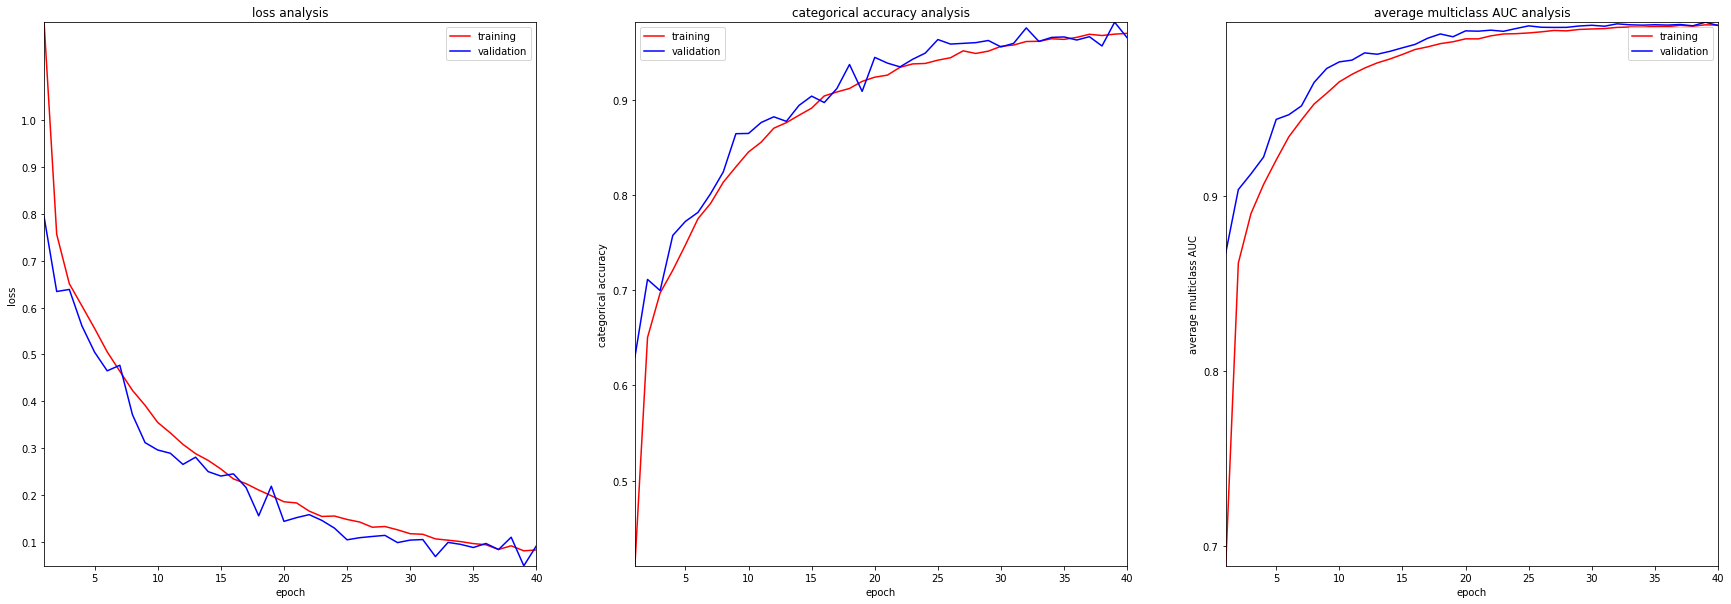

In [33]:
# Plotting graph
analyze_performances(hst, n_epochs)

**Accuracy and confusion matrix**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


The value of the loss function on the test data set is: 0.9222
The categorical accuracy of the predictions on the test data set is: 0.7628
The categorical AUC (i.e., average curve across classes) of the predictions on the test data set is: 0.9175


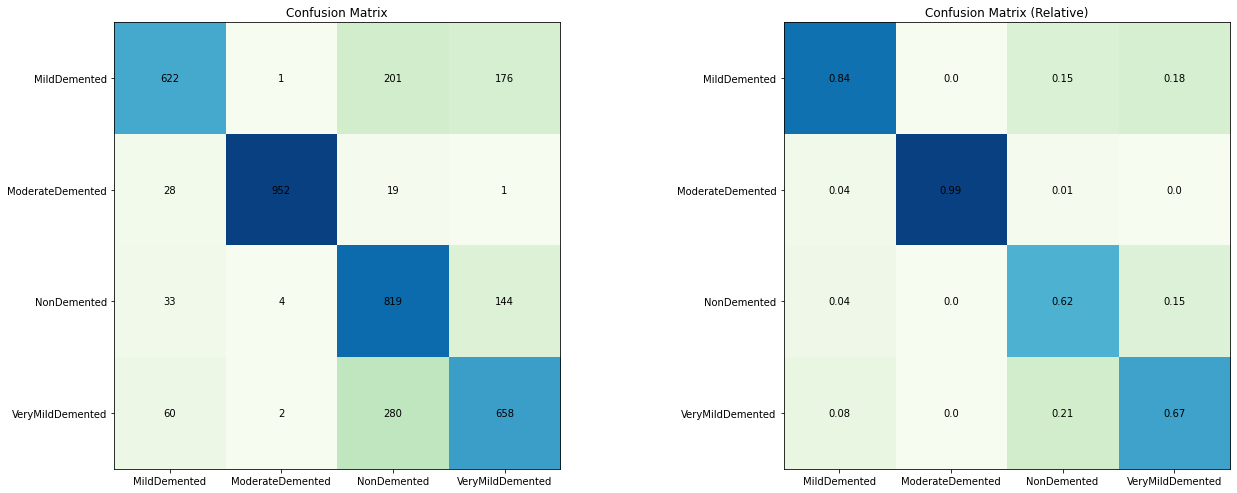

In [34]:
model_evaluation(model, test_generator)

Saving the model 

In [35]:
# serialize model to JSON
from keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [36]:
model_json

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 224, 224, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "batch_input_shape": [null, 224, 224, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d", "trainable": true, "dtype": "float32", "pool_size": [2, 2], "padding": "valid", "strides": [2, 2]